In [ ]:
import pandas as pd


# Notebook A — 01_scrape_league.ipynb

In [2]:
# Cell A1 — imports & config
import pandas as pd, requests, re
from io import StringIO
from pathlib import Path

OUT_RAW = Path("data/raw"); OUT_RAW.mkdir(parents=True, exist_ok=True)
OUT_PROC = Path("data/processed"); OUT_PROC.mkdir(parents=True, exist_ok=True)

URLS = [
    "https://m.wikipedia.org/wiki/2024%E2%80%9325_S%C3%BCper_Lig",
    "https://m.wikipedia.org/wiki/2023%E2%80%9324_S%C3%BCper_Lig",
]
HEADERS = {"User-Agent":"Mozilla/5.0","Accept-Language":"en-US,en;q=0.8"}

# Cell A2 — fetch first page that works and pick the league-like table
def get_league_table(url):
    html = requests.get(url, headers=HEADERS, timeout=30).text
    tables = pd.read_html(StringIO(html), attrs={"class":"wikitable"})
    for t in tables:
        cols = [str(c).strip().lower() for c in t.columns]
        if (("pld" in cols or "p" in cols) and ("pts" in cols or "points" in cols)):
            t.columns = [str(c).strip().lower() for c in t.columns]
            return t
    return None

df, used_url = None, None
for u in URLS:
    t = get_league_table(u)
    if t is not None:
        df, used_url = t.copy(), u
        break
if df is None:
    raise SystemExit("No league table found.")

# Cell A3 — save a raw snapshot (optional)
raw_path = OUT_RAW / "superlig_raw.csv"
df.to_csv(raw_path, index=False)
print("Saved raw to:", raw_path, "| Source:", used_url)
df.head(22)


Saved raw to: data/raw/superlig_raw.csv | Source: https://m.wikipedia.org/wiki/2024%E2%80%9325_S%C3%BCper_Lig


,pos,team,pld,w,d,l,gf,ga,gd,pts,qualification or relegation
0,1,Galatasaray (C),36,30,5,1,91,31,+60,95,Qualification for the Champions League league ...
1,2,Fenerbahçe,36,26,6,4,90,39,+51,84,Qualification for the Champions League third q...
2,3,Samsunspor,36,19,7,10,55,41,+14,64,Qualification for the Europa League play-off r...
3,4,Beşiktaş,36,17,11,8,59,36,+23,62,Qualification for the Europa League second qua...
4,5,Başakşehir,36,16,6,14,60,56,+4,54,Qualification for the Conference League second...
5,6,Eyüpspor,36,15,8,13,52,47,+5,53,NaN
6,7,Trabzonspor,36,13,12,11,58,45,+13,51,NaN
7,8,Göztepe,36,13,11,12,59,50,+9,50,NaN
8,9,Rizespor,36,15,4,17,52,58,−6,49,NaN
9,10,Kasımpaşa,36,11,14,11,62,63,−1,47,NaN


# Notebook B — 02_data_wrangling.ipynb

In [4]:
# Cell B1 — load raw, standardize columns
import pandas as pd, re
from pathlib import Path
import matplotlib.pyplot as plt

IMG = Path("imagefolder"); IMG.mkdir(parents=True, exist_ok=True)
PROC = Path("data/processed"); PROC.mkdir(parents=True, exist_ok=True)

df = pd.read_csv("data/raw/superlig_raw.csv")

# unify column names to standard set
rename_map = {
    "club":"team", "team":"team", "squad":"team",
    "pos":"pos", "position":"pos", "rank":"pos",
    "pld":"pld", "p":"pld",
    "w":"w", "d":"d", "l":"l",
    "gf":"gf", "ga":"ga", "gd":"gd",
    "pts":"pts", "points":"pts"
}
df.columns = [str(c).strip().lower() for c in df.columns]
df = df.rename(columns={c: rename_map.get(c, c) for c in df.columns})
keep = [c for c in ["team","pos","pld","w","d","l","gf","ga","gd","pts"] if c in df.columns]
df = df[keep].copy()

# types
for c in ["pos","pld","w","d","l","gf","ga","gd","pts"]:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

# save clean CSV for Tableau
clean_path = PROC / "superlig_standings_clean.csv"
df.to_csv(clean_path, index=False)
print("✅ Saved:", clean_path)
df.head(22
       )


✅ Saved: data/processed/superlig_standings_clean.csv


,team,pos,pld,w,d,l,gf,ga,gd,pts
0,Galatasaray (C),1,36,30,5,1,91,31,60.0,95.0
1,Fenerbahçe,2,36,26,6,4,90,39,51.0,84.0
2,Samsunspor,3,36,19,7,10,55,41,14.0,64.0
3,Beşiktaş,4,36,17,11,8,59,36,23.0,62.0
4,Başakşehir,5,36,16,6,14,60,56,4.0,54.0
5,Eyüpspor,6,36,15,8,13,52,47,5.0,53.0
6,Trabzonspor,7,36,13,12,11,58,45,13.0,51.0
7,Göztepe,8,36,13,11,12,59,50,9.0,50.0
8,Rizespor,9,36,15,4,17,52,58,NaN,49.0
9,Kasımpaşa,10,36,11,14,11,62,63,NaN,47.0


# Pie 1 — Fenerbahçe W–D–L

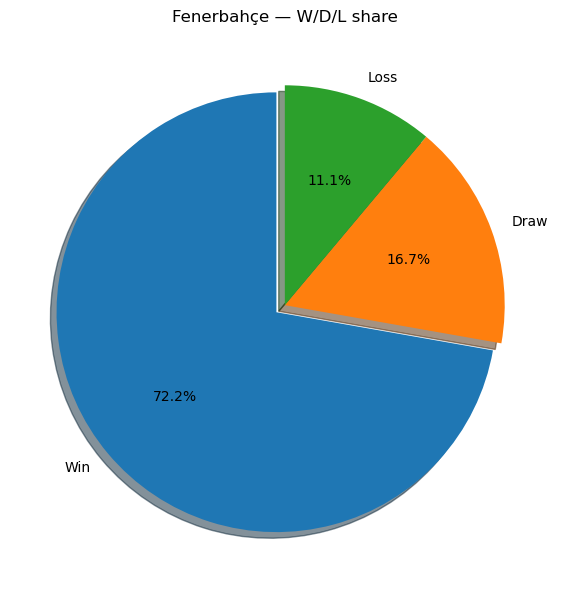

In [5]:
fen = df[df["team"].str.contains("fenerbah", case=False, na=False)].iloc[0]
sizes = [fen["w"], fen["d"], fen["l"]]
labels = ["Win","Draw","Loss"]
explode = (0.05, 0, 0)

fig = plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", explode=explode, shadow=True, startangle=90)
plt.title("Fenerbahçe — W/D/L share")
plt.tight_layout()
plt.savefig(IMG / "fenerbahce_wdl_pie.png", dpi=150, bbox_inches="tight")
plt.show()


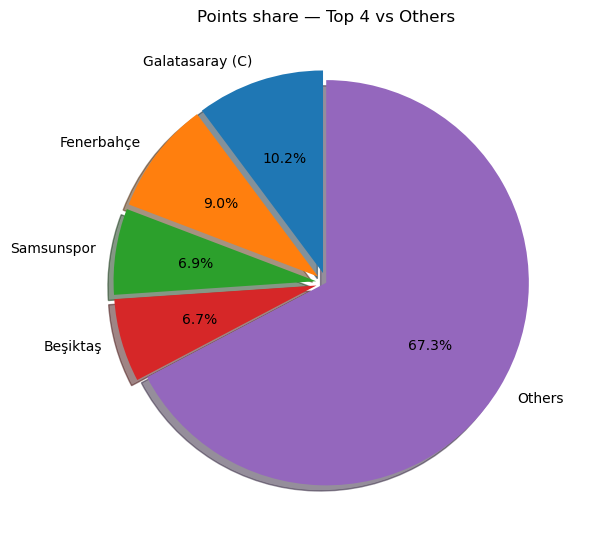

In [6]:
top = df.sort_values("pts", ascending=False).head(4)
others_pts = df["pts"].sum() - top["pts"].sum()
sizes = list(top["pts"]) + [others_pts]
labels = list(top["team"]) + ["Others"]

fig = plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", explode=[0.05]*4 + [0], shadow=True, startangle=90)
plt.title("Points share — Top 4 vs Others")
plt.tight_layout()
plt.savefig(IMG / "points_share_top4_pie.png", dpi=150, bbox_inches="tight")
plt.show()